<h1>Приведение данных</h1>

In [35]:
import zipfile
import os

Для начала распакуем наши данные:

In [7]:
print(os.listdir())

with zipfile.ZipFile("plates.zip", "r") as data:
    data.extractall()
    
print(os.listdir())

['.git', '.ipynb_checkpoints', 'Clear vs Dirty.ipynb', 'debug.log', 'plates', 'plates.zip', 'sample_submission.csv', 'submission.csv', 'test', 'train', 'val', '__MACOSX']
['.git', '.ipynb_checkpoints', 'Clear vs Dirty.ipynb', 'debug.log', 'plates', 'plates.zip', 'sample_submission.csv', 'submission.csv', 'test', 'train', 'val', '__MACOSX']


In [36]:
data_root = "plates"

Создадим папки для валидации и тренировки.

In [37]:
train_dir = "train"
val_dir = "val"

class_names = ["cleaned", "dirty"]

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

Заполним папку для трейна и валидации, чтобы в валидацию передавать каждое 6-ое изображение. (Для проверки качества модели)

In [38]:
import shutil
from tqdm import tqdm

for class_name in class_names:
    source_dir = os.path.join(data_root, "train", class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 567.76it/s]



<h1>Аугментация изображений</h1>

Так как у нас достаточно мало данных, то нам необходимо увеличить их количества с помощью аугментаций (Повороты, отзеркаливание и т п).

In [39]:
# !pip install pytorch
# !conda install -c pytorch torchvision

In [40]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy

In [41]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

Выполним аугментацию.

In [70]:
def temp_func(x):
    return x[np.random.permutation(3), :, :]

def add_transforms(dir_name, transformations=[]):
    basic_transforms = [ 
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
        transforms.Lambda(temp_func)
    ]
    
    all_images = [torchvision.datasets.ImageFolder(dir_name, transforms.Compose(basic_transforms[:]))]
    
    for transformation in transformations:
        basic_transforms.insert(0, transformation)
        all_images += [torchvision.datasets.ImageFolder(dir_name, transforms.Compose(basic_transforms[:]))]
        
    return torch.utils.data.ConcatDataset(all_images)

In [78]:
import torch
import torchvision
from torchvision import transforms, models

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

train_transforms = [transforms.RandomVerticalFlip(p=1.0), transforms.RandomHorizontalFlip(p=1.0), 
                    transforms.ColorJitter(0.6, 0.6, 0.3, 0.3), transforms.RandomRotation(45)]
# train_transforms = transforms.RandomRotation(30), transforms.ColorJitter(brightness=0, contrast=(1.25, 1.75), saturation=(1.25, 1.75), hue=(-0.1, 0.1)), transforms.RandomVerticalFlip(p=0.5), transforms.RandomHorizontalFlip(p=0.5)]

val_transforms = [transforms.RandomVerticalFlip(p=1.0), transforms.RandomHorizontalFlip(p=1.0)]
# [transforms.RandomRotation(30), transforms.ColorJitter(brightness=0, contrast=(1.25, 1.75), saturation=(1.25, 1.75), hue=(-0.1, 0.1)), transforms.RandomVerticalFlip(p=0.5), transforms.RandomHorizontalFlip(p=0.5)]

train_dataset = add_transforms(train_dir, train_transforms)

val_dataset = add_transforms(val_dir, val_transforms)
                             
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

In [81]:
itr = iter(train_dataloader)
print(len(train_dataloader), len(train_dataset))
print(len(val_dataloader), len(val_dataset))

10 160
2 24


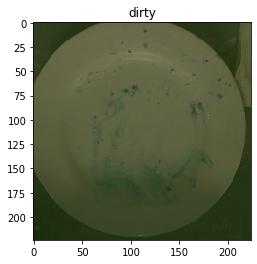

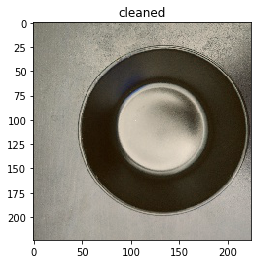

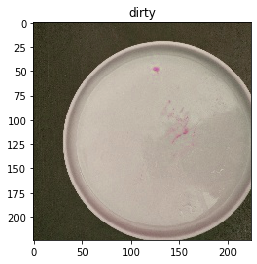

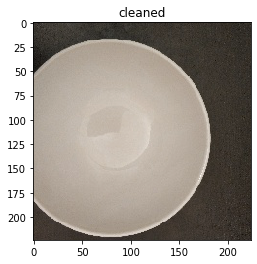

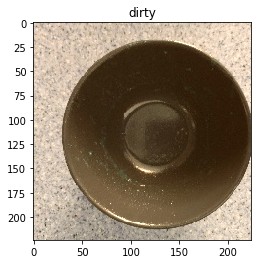

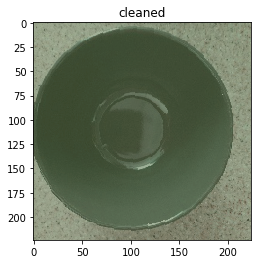

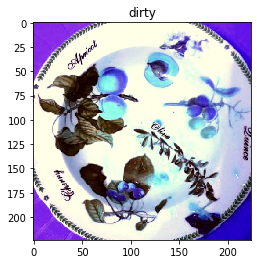

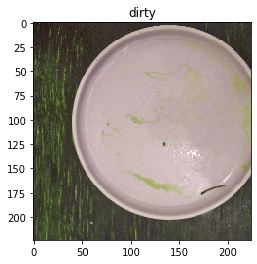

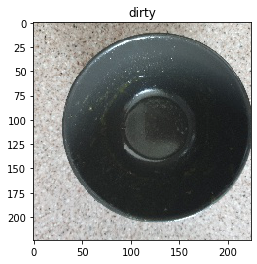

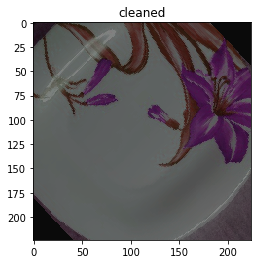

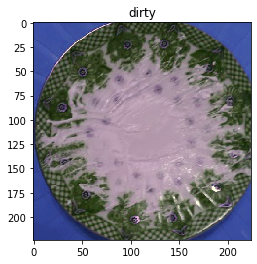

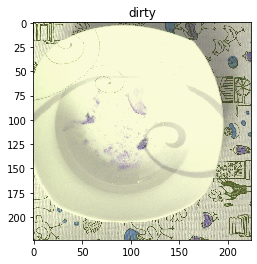

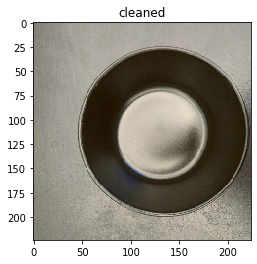

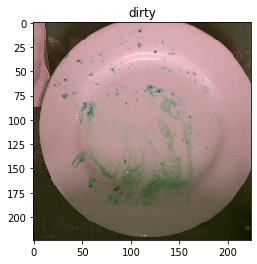

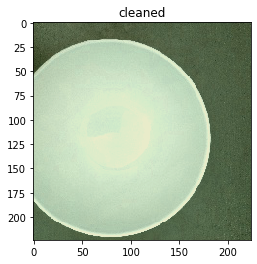

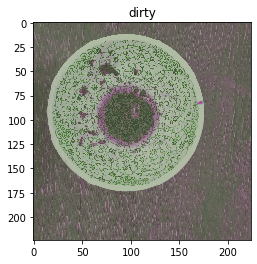

In [82]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def show_input(input_tensor, title=""):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = image * std + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(itr)

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

<h1>Обучение модели</h1>

In [48]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch, num_epochs - 1), flush=True)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()
            
            running_loss = 0
            running_acc = 0
            
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    
                    if phase == "train":
                        loss_value.backward()
                        optimizer.step()
                        
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
            
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc), flush=True) 
            
    return model

<h1>Архитектура модели</h1>

Возьмем предобученную сеть ResNet18 и дообучим ее до нашей задачи. Не забыв про регуляризацию. Иначе после 3 эпохи качество модели падает с 82% до 54%.

In [59]:
class NewLayers(torch.nn.Module):
    def __init__(self):
        super(NewLayers, self).__init__()
        self.fc1 = torch.nn.Linear(512, 1024)
        self.act1 = torch.nn.ReLU()
        self.batch1 = torch.nn.BatchNorm1d(1024)
        
        self.fc2 = torch.nn.Linear(1024, 64)
        self.act2 = torch.nn.ReLU()
        self.batch2 = torch.nn.BatchNorm1d(64)
        
        self.fc3 = torch.nn.Linear(64, 16)
        self.act3 = torch.nn.ReLU()
        self.batch3 = torch.nn.BatchNorm1d(16)
        
        self.fc4 = torch.nn.Linear(16, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.batch1(x)
        
        x = self.fc2(x)
        x = self.act2(x)
        x = self.batch2(x)
        
        x = self.fc3(x)
        x = self.act3(x)
        x = self.batch3(x)
        
        x = self.fc4(x)
        
        return x

In [60]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

model = models.resnet18(pretrained=True)

# Запретим изменение весов
for param in model.parameters():
    param.requires_grad = False

model.fc = NewLayers()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Каждые 5 итераций уменьшает lr на 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

<h1>Тренировка модели</h1>

In [61]:
train_model(model, loss, optimizer, scheduler, num_epochs=31) 

Epoch 0/30:


100%|██████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]

train Loss: 0.4827 Acc: 0.7875



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]

val Loss: 0.5622 Acc: 0.7812
Epoch 1/30:



100%|██████████████████████████████████████████| 10/10 [00:16<00:00,  1.62s/it]

train Loss: 0.3512 Acc: 0.8750



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]

val Loss: 0.4733 Acc: 0.8125
Epoch 2/30:



100%|██████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]

train Loss: 0.2618 Acc: 0.9187



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/it]

val Loss: 0.3087 Acc: 1.0000
Epoch 3/30:



100%|██████████████████████████████████████████| 10/10 [00:15<00:00,  1.53s/it]

train Loss: 0.2319 Acc: 0.9250



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]

val Loss: 0.3381 Acc: 0.8750
Epoch 4/30:



100%|██████████████████████████████████████████| 10/10 [00:15<00:00,  1.60s/it]

train Loss: 0.1676 Acc: 0.9688



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.18s/it]

val Loss: 0.2606 Acc: 0.9062
Epoch 5/30:



100%|██████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]

train Loss: 0.1370 Acc: 0.9937



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]

val Loss: 0.4906 Acc: 0.7812
Epoch 6/30:



100%|██████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]

train Loss: 0.1375 Acc: 0.9875



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.31s/it]

val Loss: 0.3404 Acc: 0.8750
Epoch 7/30:



100%|██████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]

train Loss: 0.1328 Acc: 0.9875



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.26s/it]

val Loss: 0.3077 Acc: 0.8438
Epoch 8/30:



100%|██████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]

train Loss: 0.2321 Acc: 0.9250



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]

val Loss: 0.2998 Acc: 0.8750
Epoch 9/30:



100%|██████████████████████████████████████████| 10/10 [00:17<00:00,  1.70s/it]

train Loss: 0.1073 Acc: 0.9937



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]

val Loss: 0.4469 Acc: 0.8125
Epoch 10/30:



100%|██████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]

train Loss: 0.1646 Acc: 0.9812



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.15s/it]

val Loss: 0.3063 Acc: 0.8750
Epoch 11/30:



100%|██████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]

train Loss: 0.2356 Acc: 0.9187



100%|████████████████████████████████████████████| 2/2 [00:02<00:00,  1.09s/it]

val Loss: 0.2823 Acc: 0.8750
Epoch 12/30:



100%|██████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]

train Loss: 0.1351 Acc: 0.9688



100%|████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]

val Loss: 0.2677 Acc: 0.8750
Epoch 13/30:



  0%|                                                   | 0/10 [00:01<?, ?it/s]


KeyboardInterrupt: 

<h1>Сохранение результатов</h1>

In [62]:
test_dir = 'test'
# shutil.copytree(os.path.join('plates', 'test'), os.path.join(test_dir, 'unknown'))

In [63]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test',  transforms.Compose([
        transforms.CenterCrop((224, 224)),
        # transforms.ColorJitter(brightness=0, contrast=(1.25, 1.75), saturation=(1.25, 1.75), hue=(-0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]))

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [64]:
test_dataloader

In [65]:
model.eval()

test_predictions = []
test_img_paths = []

for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████████████████████████████████████| 47/47 [01:34<00:00,  2.01s/it]


In [66]:
itr = iter(test_dataloader)

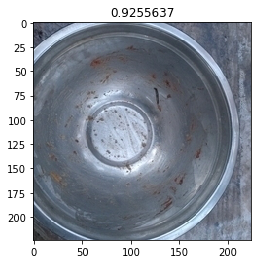

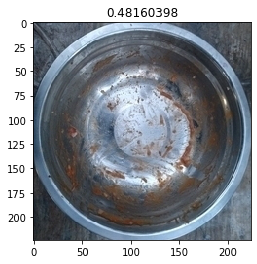

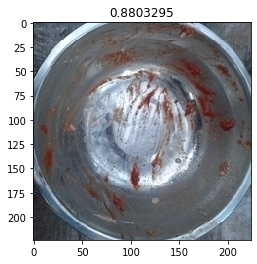

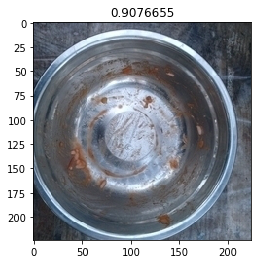

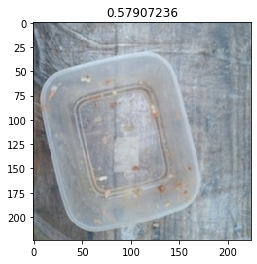

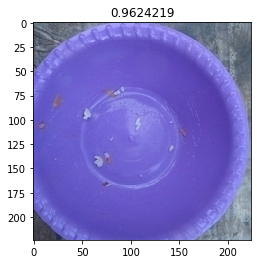

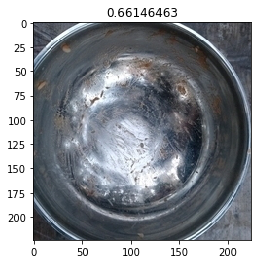

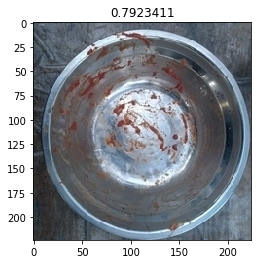

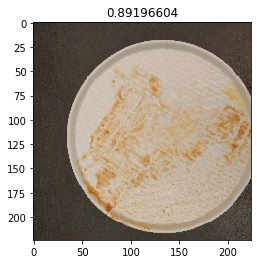

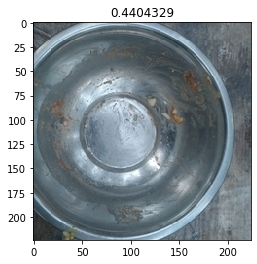

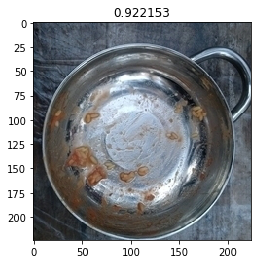

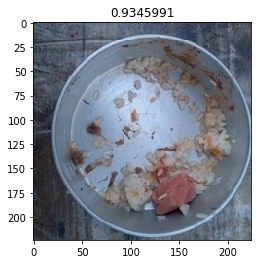

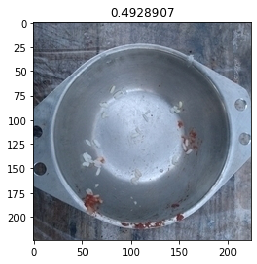

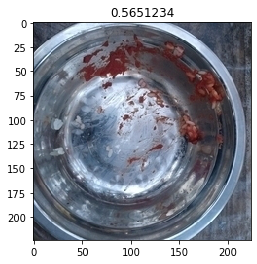

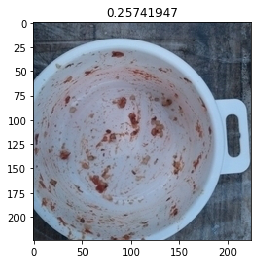

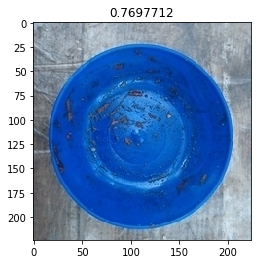

In [69]:
inputs, labels, paths = next(itr)

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('\\', '').str.replace("testunknown", "")
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

In [ ]:
submission_df.to_csv('submission.csv')